# 

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score

Пример без лагов

In [30]:
# Создаем синтетические данные
np.random.seed(50)
n_samples = 10000

# Рейтинги (пример порядка)
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC', 'D']
company_types = ['bank', 'oil', 'tech', 'retail', 'telecom']

data = pd.DataFrame({
    'rating': np.random.choice(ratings, size=n_samples),
    'date': pd.date_range(start='2020-01-01', periods=n_samples, freq='D'),
    'company_type': np.random.choice(company_types, size=n_samples),
    'inn': np.random.randint(1000,2000, size=n_samples)  # просто случайные ИНН
})

In [32]:
# ① Кодируем рейтинг (ординально, если есть порядок)
rating_order = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC', 'D']  # от лучшего к худшему
encoder = OrdinalEncoder(categories=[rating_order])
data['rating_encoded'] = encoder.fit_transform(data[['rating']])

# ② Временные фичи
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# ③ Категориальные фичи (One-Hot для типа компании)
data = pd.get_dummies(data, columns=['company_type'])

# ④ Агрегаты по ИНН (пример: сколько раз встречается компания)
data['inn_count'] = data.groupby('inn')['inn'].transform('count')

# Удаляем ненужные столбцы
data = data.drop(['inn', 'date'], axis=1)

In [34]:
# Фичи и целевая переменная
X = data.drop(['rating', 'rating_encoded'], axis=1)
y = data['rating_encoded']

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=rating_order))

Accuracy: 0.11
              precision    recall  f1-score   support

         AAA       0.10      0.11      0.11       298
         AA+       0.11      0.12      0.11       310
          AA       0.17      0.15      0.16       337
         BBB       0.14      0.13      0.13       372
         BB+       0.12      0.13      0.13       344
          BB       0.08      0.08      0.08       346
           B       0.09      0.10      0.10       317
         CCC       0.11      0.10      0.10       347
           D       0.11      0.10      0.10       329

    accuracy                           0.11      3000
   macro avg       0.11      0.11      0.11      3000
weighted avg       0.11      0.11      0.11      3000



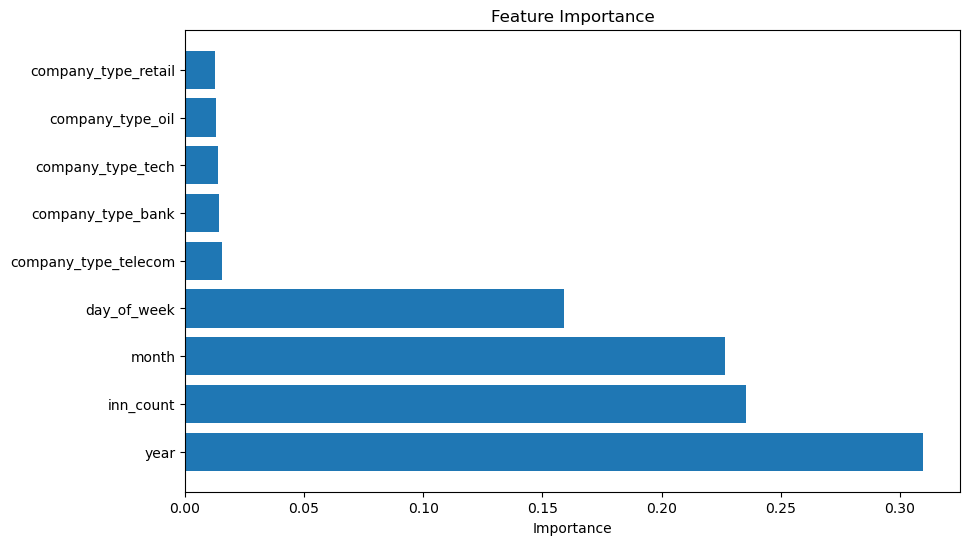

In [35]:
import matplotlib.pyplot as plt

# Важность фичей
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

Пример с лагами

In [39]:
np.random.seed(42)
n_companies = 500  # 50 компаний
n_months = 24     # 2 года данных (24 месяца)
n_samples = 10000
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC']
data = pd.DataFrame({
    'inn': np.random.randint(1000,2000, size=n_samples),
    'date': pd.date_range(start='2020-01-01', periods=n_months, freq='ME').tolist() * n_companies,
    'rating': np.random.choice(ratings, size=n_companies * n_months, p=[0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02])
})
print(data['inn'].unique())

ValueError: All arrays must be of the same length

In [41]:
np.random.seed(42)
n_companies = 5000
n_months = 24
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC']
rating_probs = [0.1, 0.15, 0.15, 0.15, 0.1, 0.1, 0.15, 0.1]

# Создаем компании с разными характеристиками
companies = pd.DataFrame({
    'inn': np.random.randint(1000, 2000, size=n_companies),
    'company_type': np.random.choice(['bank', 'oil', 'tech', 'retail', 'manufacturing'], size=n_companies),
    'base_rating': np.random.choice(ratings, size=n_companies, p=rating_probs)
})

# Генерируем временные ряды для каждой компании
data = []
for _, company in companies.iterrows():
    dates = pd.date_range(start='2020-01-01', periods=n_months, freq='ME')
    base_rating_idx = ratings.index(company['base_rating'])
    
    # Генерируем рейтинги с некоторой динамикой
    rating_idxs = np.clip(
        base_rating_idx + np.cumsum(np.random.normal(0, 0.3, n_months)).round().astype(int),
        0, len(ratings)-1
    )
    company_ratings = [ratings[i] for i in rating_idxs]
    
    data.extend([{
        'inn': company['inn'],
        'date': date,
        # 'company_type': company['company_type'],
        'rating': rating,
        'months_since_start': i
    } for i, (date, rating) in enumerate(zip(dates, company_ratings))])

data = pd.DataFrame(data)

In [42]:
# ② Временные фичи
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# # ③ Категориальные фичи (One-Hot для типа компании)
# data = pd.get_dummies(data, columns=['company_type'])

# ④ Агрегаты по ИНН (пример: сколько раз встречается компания)
data['inn_count'] = data.groupby('inn')['inn'].transform('count')


In [58]:
# --- 2. Добавляем лаги рейтинга ---
data = data.sort_values(['inn', 'date'])

for lag in [1, 3, 6, 12]:
    data[f'rating_lag_{lag}'] = data.groupby('inn')['rating'].shift(lag)

# Удаляем строки с NaN (где нет истории)
data = data.dropna()


In [60]:
# --- 3. Правильное кодирование ---
# Создаем словарь для ручного кодирования
rating_to_code = {rating: i for i, rating in enumerate(rating_order)}

# Применяем кодирование ко всем столбцам с рейтингами
data['rating_encoded'] = data['rating'].map(rating_to_code)
for lag in [1, 3, 6, 12]:
    col = f'rating_lag_{lag}'
    data[col] = data[col].map(rating_to_code)
# Разница с предыдущим рейтингом
data['rating_diff_1'] = data.groupby('inn')['rating_encoded'].diff(1).fillna(0)
data['rating_diff_2'] = data.groupby('inn')['rating_encoded'].diff(2).fillna(0)
data['rating_diff_3'] = data.groupby('inn')['rating_encoded'].diff(3).fillna(0)
print(data['rating_diff_1'].unique())
print(data['rating_diff_2'].unique())
print(data['rating_diff_3'].unique())

[ 0. -1.  3.  2. -3. -2.  4.  1.  7. -4.  5. -6. -5.  6. -7.]
[ 0. -1.  2.  5. -3. -2.  1.  4.  3. -5.  6. -4. -6. -7.  7.]
[ 0. -2.  2.  4. -1. -5.  3.  5. -6.  1.  6. -4. -3. -7.  7.]


In [62]:
data.dropna()

,inn,date,rating,months_since_start,year,month,day_of_week,inn_count,rating_encoded,rating_diff_1,rating_diff_2,rating_diff_3,rating_lag_1,rating_lag_3,rating_lag_6,rating_lag_12
38041,1000,2020-02-29,BBB,1,2020,2,5,216,3,0.0,0.0,0.0,1,3,1,3
66241,1000,2020-02-29,AA,1,2020,2,5,216,2,-1.0,0.0,0.0,3,3,4,3
68137,1000,2020-02-29,AA,1,2020,2,5,216,2,0.0,-1.0,0.0,2,1,6,1
101617,1000,2020-02-29,AA+,1,2020,2,5,216,1,-1.0,-1.0,-2.0,2,3,3,3
108265,1000,2020-02-29,BB+,1,2020,2,5,216,4,3.0,2.0,2.0,1,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89803,1999,2021-08-31,BBB,19,2021,8,1,24,3,1.0,1.0,1.0,2,2,2,1
89804,1999,2021-09-30,BBB,20,2021,9,3,24,3,0.0,1.0,1.0,3,2,2,2
89805,1999,2021-10-31,BBB,21,2021,10,6,24,3,0.0,0.0,1.0,3,2,2,2
89806,1999,2021-11-30,BBB,22,2021,11,1,24,3,0.0,0.0,0.0,3,3,2,2


In [64]:
# --- 4. Фичи и обучение ---
# X = data.filter(like='lag_')  # Только лаги
# y = data['rating_encoded']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestClassifier(n_estimators=200, random_state=42)
# model.fit(X_train, y_train)
exclude_cols = ['inn', 'date', 'rating', 'rating_encoded']
X = data.drop(exclude_cols, axis=1)
y = data['rating_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Обучение модели ---
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    # class_weight='balanced'  # Для несбалансированных данных
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [65]:
# --- 5. Оценка ---
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='micro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='micro'):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred, average='micro'):.2f}")
# print(classification_report(y_test, y_pred, target_names=rating_order))

# Важность фичей
# pd.DataFrame({
#     'feature': X.columns,
#     'importance': model.feature_importances_
# }).sort_values('importance', ascending=False)


Accuracy: 0.94
Recall: 0.94
Precision: 0.94
F1 score: 0.94


In [1]:
# Выбираем, например, 0-е дерево из леса
estimator = model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator,
          feature_names=X.columns,
          class_names=[str(cls) for cls in model.classes_],
          filled=True,
          rounded=True,
          max_depth=3  # Можно увеличить для большей глубины
         )
plt.title("Первое дерево из Random Forest")
plt.show()


NameError: name 'model' is not defined

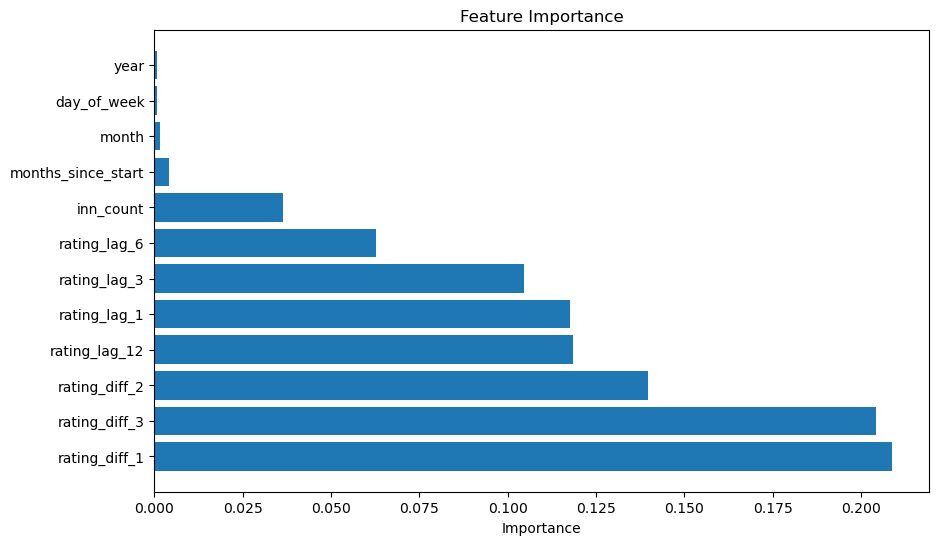

In [66]:
import matplotlib.pyplot as plt

# Важность фичей
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

А теперь на реальных данных с подуровнем

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [3]:
# for macos
# data = pd.read_excel("/Users/danilalipatov/PycharmProjects/diploma/resemple_data_cat_level_cat.xlsx")
# for windows
data = pd.read_excel(r"C:\Users\Danch\Downloads\Telegram Desktop\resemple_data_cat_level_cat.xlsx")
data

,Unnamed: 0,identifier,agency,_ro_type,resampled_dates,resampled_values,rating_category
0,0,5200000046,Expert RA,BNFC - нефинансовая компания,2009-02-28,20,D
1,1,5200000046,Expert RA,BNFC - нефинансовая компания,2009-03-31,20,D
2,2,5200000046,Expert RA,BNFC - нефинансовая компания,2009-04-30,20,D
3,3,5200000046,Expert RA,BNFC - нефинансовая компания,2009-05-31,20,D
4,4,5200000046,Expert RA,BNFC - нефинансовая компания,2009-06-30,20,D
...,...,...,...,...,...,...,...
99174,99174,9728011653,AKRA,"FOFO - прочие финансовые организации, в том чи...",2024-11-30,7,A-
99175,99175,2310197022,NRA,BNFC - нефинансовая компания,2024-11-30,13,BB-
99176,99176,2721128498,Expert RA,BNFC - нефинансовая компания,2024-11-30,5,A+
99177,99177,7835905228,AKRA,CBNK - кредитная организация,2024-11-30,6,A


In [4]:
inn = 'identifier'
date = 'resampled_dates'
num_ = 'resampled_values'
category = 'rating_category'
agency = 'agency'
_ro_type = '_ro_type'
current_agency = 'NCR'
current_ro_type = ['FINS - страховая организация']
print(data["_ro_type"].unique())
# print(len(data[inn].unique()))

['BNFC - нефинансовая компания' 'CBNK - кредитная организация'
 'FLSG - лизинговая компания (фирма)'
 'FOFO - прочие финансовые организации, в том числе специализированные общества'
 'CO - прочий вид организации' 'FNPF - негосударственный пенсионный фонд'
 'FINS - страховая организация'
 'BNFH - холдинговая компания (нефинансовая)'
 'FMFO - микрофинансовая организация' 'FDEP - депозитарий'
 'FFCT - юридическое лицо, специализирующееся на предоставлении финансирования под уступку денежного требования (факторинговая компания)'
 'IFO - международная финансовая организация']


In [5]:
data [(data[agency] == current_agency)][_ro_type].unique()

array(['BNFC - нефинансовая компания', 'CBNK - кредитная организация',
       'FINS - страховая организация',
       'FLSG - лизинговая компания (фирма)',
       'CO - прочий вид организации',
       'BNFH - холдинговая компания (нефинансовая)'], dtype=object)

In [6]:
# ручной фильтр
# data[(data[agency] == current_agency) & (data[_ro_type] == current_ro_type)]
data = data [(data[agency] == current_agency) & (data[_ro_type].isin(current_ro_type))]

In [7]:
data

,Unnamed: 0,identifier,agency,_ro_type,resampled_dates,resampled_values,rating_category
6499,6499,7710045520,NCR,FINS - страховая организация,2020-02-29,1,AAA
6500,6500,7710045520,NCR,FINS - страховая организация,2020-03-31,1,AAA
6501,6501,7710045520,NCR,FINS - страховая организация,2020-04-30,1,AAA
6502,6502,7710045520,NCR,FINS - страховая организация,2020-05-31,1,AAA
6503,6503,7710045520,NCR,FINS - страховая организация,2020-06-30,1,AAA
...,...,...,...,...,...,...,...
98383,98383,1655034323,NCR,FINS - страховая организация,2024-07-31,5,A+
98384,98384,1655034323,NCR,FINS - страховая организация,2024-08-31,5,A+
98385,98385,1655034323,NCR,FINS - страховая организация,2024-09-30,5,A+
98386,98386,1655034323,NCR,FINS - страховая организация,2024-10-31,5,A+


In [8]:
data[_ro_type].unique()

array(['FINS - страховая организация'], dtype=object)

In [9]:
# --- Предобработка ---
data[date] = pd.to_datetime(data[date])
data = data.sort_values([inn, date])

# Лаги
data['rating_diff_1'] = data.groupby(inn)[num_].diff(1).fillna(0)
data['rating_diff_2'] = data.groupby(inn)[num_].diff(2).fillna(0)
data['rating_diff_3'] = data.groupby(inn)[num_].diff(3).fillna(0)
data['rating_diff_4'] = data.groupby(inn)[num_].diff(4).fillna(0)
data['rating_diff_5'] = data.groupby(inn)[num_].diff(5).fillna(0)
data['rating_diff_6'] = data.groupby(inn)[num_].diff(6).fillna(0)
data['rating_diff_7'] = data.groupby(inn)[num_].diff(5).fillna(0)
data['rating_diff_8'] = data.groupby(inn)[num_].diff(6).fillna(0)
data['rating_diff_9'] = data.groupby(inn)[num_].diff(5).fillna(0)

# for lag in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
# for lag in [12, 24, 36, 48]:
for lag in [1, 2, 3, 4]:
    data[f'rating_lag_{lag}'] = data.groupby(inn)[num_].shift(lag).dropna()
    print(f'rating_lag_{lag}')
print(data['rating_diff_1'].unique())
print(data['rating_diff_2'].unique())
print(data['rating_diff_3'].unique())
# Временные признаки
data['year'] = data[date].dt.year
data['month'] = data[date].dt.month
data['day_of_week'] = data[date].dt.dayofweek

# Метки
data['inn_count'] = data.groupby(inn)[inn].transform('count')

# Возраст компании
first_seen = data.groupby(inn)[date].transform('min')
data['company_age_months'] = ((data[date] - first_seen) / np.timedelta64(1, 'm')).astype(int)

# --- Подготовка признаков ---
categorical_features = [agency, _ro_type]
numerical_features = [
    'year', 'month', 'day_of_week',
    'inn_count', 'company_age_months', 
    'rating_lag_1', 'rating_lag_2', 'rating_lag_3', 'rating_lag_4'
    # 'rating_diff_1', 'rating_diff_2', 'rating_diff_3', 'rating_diff_4', 'rating_diff_5', 'rating_diff_6',
    # 'rating_lag_1', 'rating_lag_2', 'rating_lag_3', 'rating_lag_4', 'rating_lag_5', 'rating_lag_6', 'rating_lag_7', 'rating_lag_8', 'rating_lag_9', 'rating_lag_10','rating_lag_11','rating_lag_12', 
    # 'rating_lag_12','rating_lag_24','rating_lag_36','rating_lag_48',
]

features = categorical_features + numerical_features
# features = numerical_features
# Удалим пропуски
data = data.dropna(subset=features + [num_])

X = data[features]
y = data[num_].astype(int)

rating_lag_1
rating_lag_2
rating_lag_3
rating_lag_4
[ 0. -1. -2.]
[ 0. -1. -2.]
[ 0. -1. -2.]


C:\Users\Danch\AppData\Local\Temp\ipykernel_18376\4173686655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date] = pd.to_datetime(data[date])


In [10]:
len(data[inn].unique())

20

In [11]:
# --- Pipeline ---
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numerical_features)
])
# preprocessor = ColumnTransformer([
#     ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
#     ('num', 'passthrough', numerical_features)
# ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=2000))
])

In [12]:
# --- Обучение ---
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
print(X_train.columns, y_train.name)
pipeline.fit(X_train, y_train)

Index(['agency', '_ro_type', 'year', 'month', 'day_of_week', 'inn_count',
       'company_age_months', 'rating_lag_1', 'rating_lag_2', 'rating_lag_3',
       'rating_lag_4'],
      dtype='object') resampled_values


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['agency', '_ro_type']),
                                                 ('num', 'passthrough',
                                                  ['year', 'month',
                                                   'day_of_week', 'inn_count',
                                                   'company_age_months',
                                                   'rating_lag_1',
                                                   'rating_lag_2',
                                                   'rating_lag_3',
                                                   'rating_lag_4'])])),
                ('classifier', RandomForestClassifier(n_estimators=2000))])

In [13]:
# --- Оценка ---
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
precision_weight = precision_score(y_test, y_pred, average='weighted')
recall_weight = recall_score(y_test, y_pred, average='weighted')
f1_weight = f1_score(y_test, y_pred, average='weighted')
# Выводим метрики
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print(f'Precision_weighted: {precision_weight:.2f}')
print(f'Recall_weighted: {recall_weight:.2f}')
print(f'F1 Score_weighted: {f1_weight:.2f}')

              precision    recall  f1-score   support

           1       0.98      1.00      0.99        47
           2       1.00      0.43      0.60         7
           3       0.94      1.00      0.97        48
           7       1.00      1.00      1.00        23

    accuracy                           0.97       125
   macro avg       0.98      0.86      0.89       125
weighted avg       0.97      0.97      0.96       125

Accuracy: 0.97
Precision: 0.98
Recall: 0.86
F1 Score: 0.89
Precision_weighted: 0.97
Recall_weighted: 0.97
F1 Score_weighted: 0.96


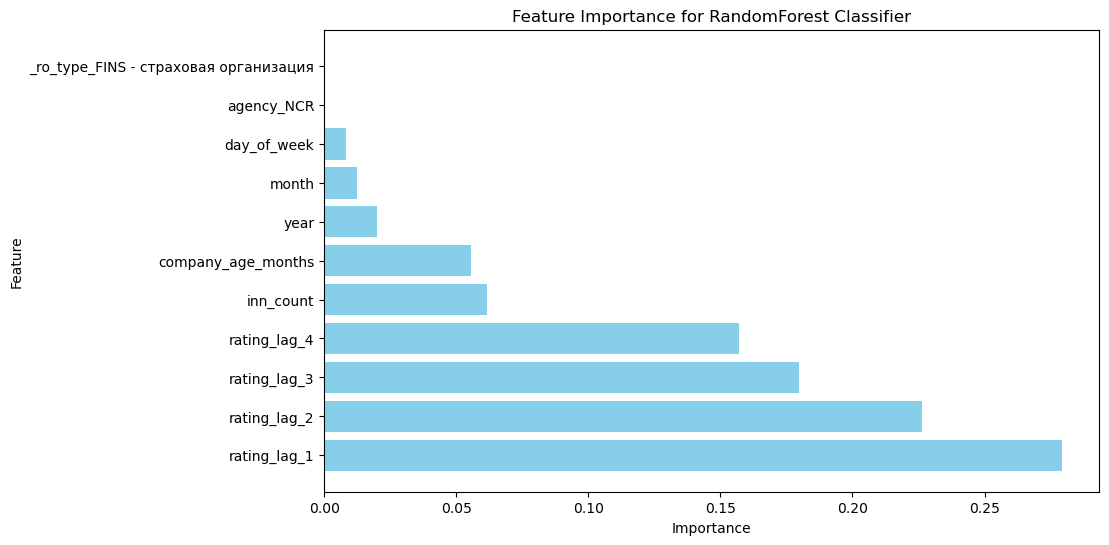

                                  Feature  Importance
7                            rating_lag_1    0.279415
8                            rating_lag_2    0.226298
9                            rating_lag_3    0.179790
10                           rating_lag_4    0.157116
5                               inn_count    0.061566
6                      company_age_months    0.055480
2                                    year    0.019931
3                                   month    0.012320
4                             day_of_week    0.008083
0                              agency_NCR    0.000000
1   _ro_type_FINS - страховая организация    0.000000


In [14]:
# Получение важности фичей
# Важно, что для извлечения важности нужно обратиться к "classifier" внутри pipeline
importances = pipeline.named_steps['classifier'].feature_importances_

# Получаем список всех фичей (категориальные и числовые)
all_features = (pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() + numerical_features)
# all_features = numerical_features
# Создание DataFrame для отображения важности фичей
feature_importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})

# Сортировка фичей по важности
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# --- График важности фичей ---
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for RandomForest Classifier')
plt.show()

# Выводим важность фичей
print(feature_importances)

In [18]:
print(pipeline.named_steps)

{'preprocessor': ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['agency', '_ro_type']),
                                ('num', 'passthrough',
                                 ['year', 'month', 'day_of_week', 'inn_count',
                                  'company_age_months', 'rating_lag_1',
                                  'rating_lag_2', 'rating_lag_3',
                                  'rating_lag_4'])]), 'classifier': RandomForestClassifier(n_estimators=2000)}


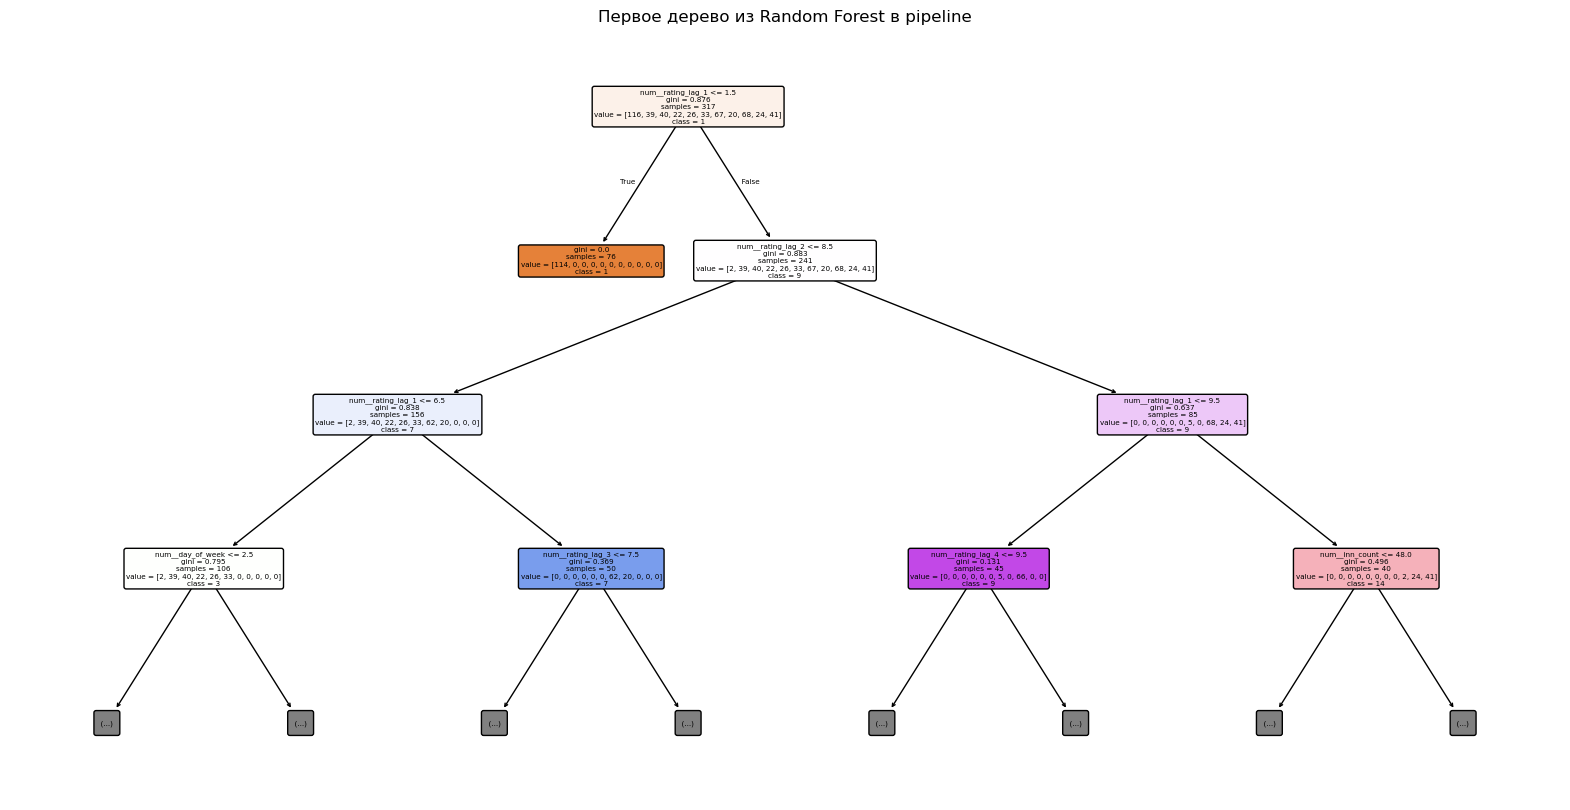

In [22]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Извлекаем первое дерево
rf_model = pipeline.named_steps['classifier']
estimator = rf_model.estimators_[0]

# Рисуем дерево
plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(),
    class_names=[str(cls) for cls in rf_model.classes_],
    filled=True,
    rounded=True,
    max_depth=3  # для лучшей читаемости
)
plt.title("Первое дерево из Random Forest в pipeline")
plt.show()

In [24]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import os

# Извлекаем обученную модель
rf_model = pipeline.named_steps['classifier']

# Извлекаем трансформеры из препроцессора
preprocessor = pipeline.named_steps['preprocessor']
ohe = preprocessor.named_transformers_['cat']  # OneHotEncoder

# Категориальные и числовые признаки
categorical_features = ['agency', '_ro_type']
numerical_features = ['year', 'month', 'day_of_week', 'inn_count',
                      'company_age_months', 'rating_lag_1',
                      'rating_lag_2', 'rating_lag_3', 'rating_lag_4']

# Получаем имена после OneHotEncoding
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# Объединяем итоговые имена признаков
feature_names = list(cat_feature_names) + numerical_features

# Создаём директорию для файлов
os.makedirs("trees", exist_ok=True)

# Визуализируем первые 3 дерева
for i, tree in enumerate(rf_model.estimators_[:3]):
    plt.figure(figsize=(20, 10))
    plot_tree(tree,
              feature_names=feature_names,
              class_names=[str(cls) for cls in rf_model.classes_],
              filled=True,
              rounded=True,
              max_depth=3)
    plt.title(f"Дерево №{i}")
    plt.savefig(f"trees/tree_{i}.png")
    plt.close()


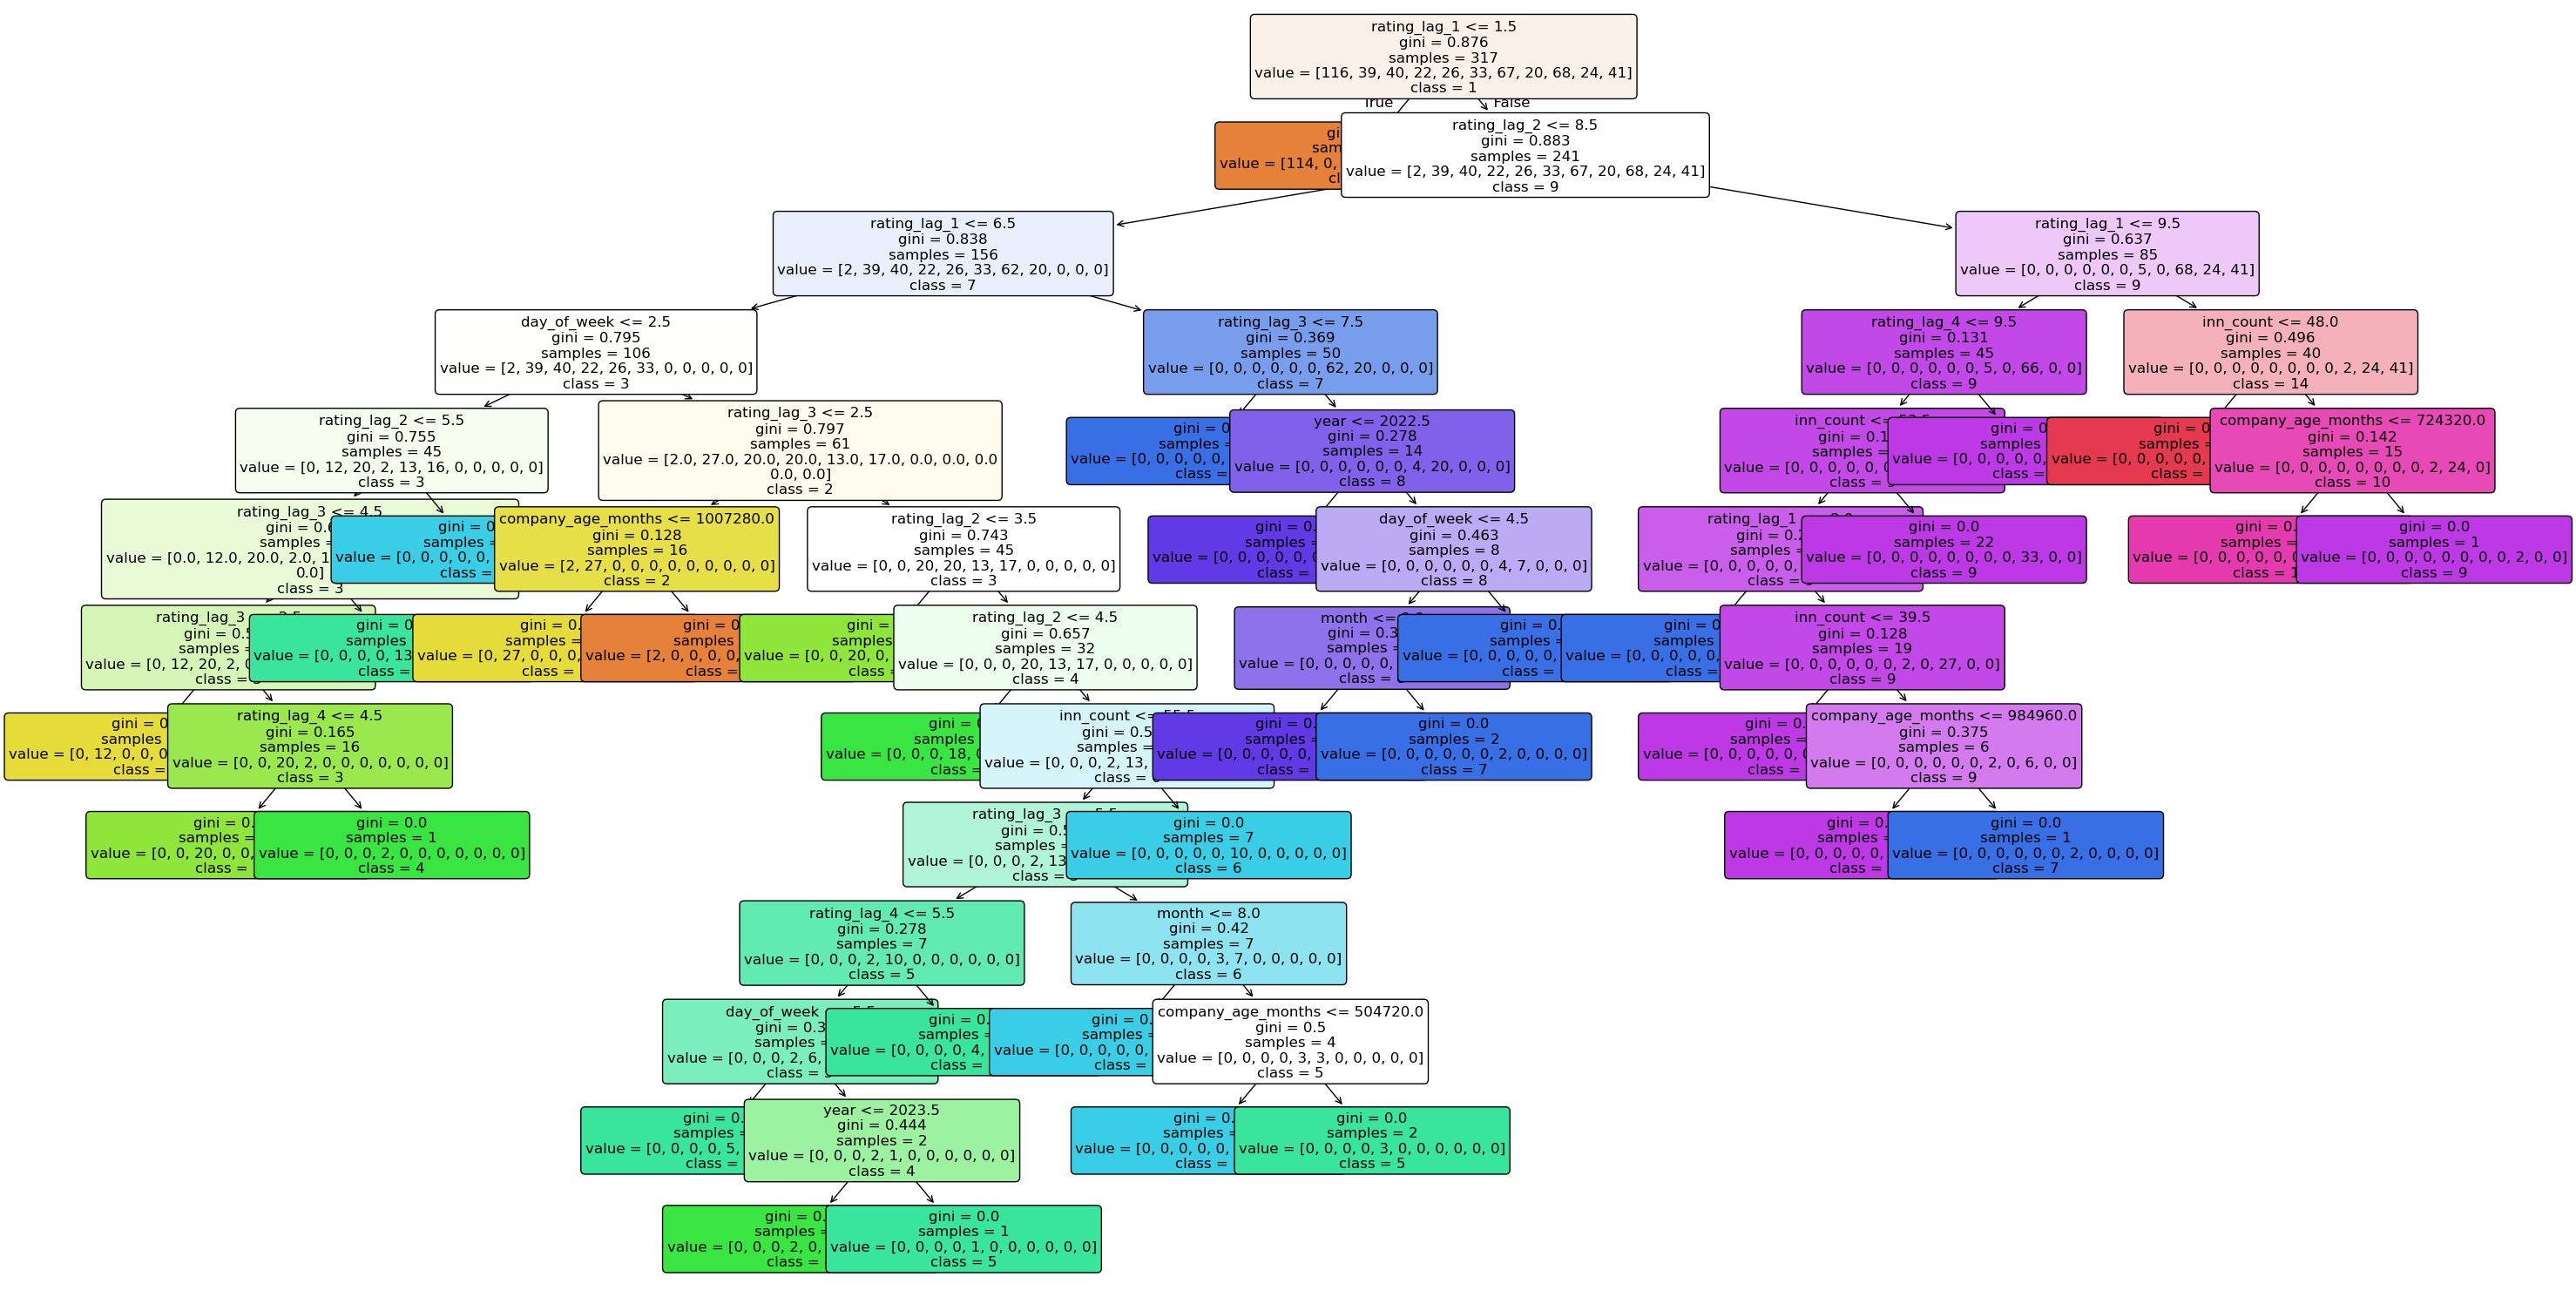

In [25]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

rf_model = pipeline.named_steps['classifier']
estimator = rf_model.estimators_[0]

plt.figure(figsize=(30, 15))  # больше — лучше читается
plot_tree(estimator,
          feature_names=feature_names,
          class_names=[str(i) for i in rf_model.classes_],
          filled=True,
          rounded=True,
          fontsize=12)

plt.tight_layout()
plt.show()


In [582]:
len(data[inn].unique())

20

Предсказания:

In [583]:
def predict_next_rating(model, last_rows: pd.DataFrame) -> int:
    # Сортировка по дате
    last_rows = last_rows.sort_values("resampled_dates")
    
    # Вычисление разницы рейтинга
    diffs = last_rows[num_].diff().fillna(0)
    
    # Разница по рейтингу для нескольких периодов
    rating_diff_1 = diffs.iloc[-1]
    rating_diff_2 = diffs.iloc[-2] if len(diffs) > 1 else 0
    rating_diff_3 = diffs.iloc[-3] if len(diffs) > 2 else 0
    rating_diff_4 = diffs.iloc[-4] if len(diffs) > 3 else 0
    rating_diff_5 = diffs.iloc[-5] if len(diffs) > 4 else 0
    rating_diff_6 = diffs.iloc[-6] if len(diffs) > 5 else 0
    rating_diff_7 = diffs.iloc[-7] if len(diffs) > 6 else 0
    rating_diff_8 = diffs.iloc[-8] if len(diffs) > 7 else 0
    rating_diff_9 = diffs.iloc[-9] if len(diffs) > 8 else 0
    
    last_date = pd.to_datetime(last_rows["resampled_dates"].iloc[-1])
    start_date = pd.to_datetime(last_rows["resampled_dates"].min())
    year = last_date.year
    month = last_date.month + 1 if last_date.month < 12 else 1
    day_of_week = (last_date + pd.DateOffset(months=1)).dayofweek

    # Вычисление возраста компании
    company_age = (last_date.year - start_date.year) * 12 + (last_date.month - start_date.month)

    # Вычисление месяцев с начала
    months_since_start = company_age  # Это можно доработать, если нужна более точная формула

    # Лаги рейтинга
    rating_lag_1 = last_rows[num_].iloc[-2] if len(last_rows) > 1 else 0
    rating_lag_2 = last_rows[num_].iloc[-3] if len(last_rows) > 2 else 0
    rating_lag_3 = last_rows[num_].iloc[-4] if len(last_rows) > 3 else 0
    rating_lag_4 = last_rows[num_].iloc[-5] if len(last_rows) > 3 else 0
    rating_lag_5 = last_rows[num_].iloc[-6] if len(last_rows) > 5 else 0
    rating_lag_6 = last_rows[num_].iloc[-7] if len(last_rows) > 6 else 0
    rating_lag_7 = last_rows[num_].iloc[-8] if len(last_rows) > 7 else 0
    rating_lag_8 = last_rows[num_].iloc[-9] if len(last_rows) > 8 else 0
    rating_lag_9 = last_rows[num_].iloc[-10] if len(last_rows) > 9 else 0
    rating_lag_10 = last_rows[num_].iloc[-11] if len(last_rows) > 10 else 0
    rating_lag_11 = last_rows[num_].iloc[-12] if len(last_rows) > 11 else 0
    rating_lag_12 = last_rows[num_].iloc[-13] if len(last_rows) > 12 else 0
    rating_lag_24 = last_rows[num_].iloc[-25] if len(last_rows) > 24 else 0
    rating_lag_36 = last_rows[num_].iloc[-37] if len(last_rows) > 36 else 0
    rating_lag_48 = last_rows[num_].iloc[-49] if len(last_rows) > 48 else 0
    # Дополнительная информация
    inn_count = len(last_rows)
    row = last_rows.iloc[-1]
    
    # Создание входных данных для модели
    input_data = pd.DataFrame([{
        # 'rating_diff_1': rating_diff_1,
        # 'rating_diff_2': rating_diff_2,
        # 'rating_diff_3': rating_diff_3,
        # 'rating_diff_4': rating_diff_4,
        # 'rating_diff_5': rating_diff_5,
        # 'rating_diff_6': rating_diff_6,
        # 'rating_diff_7': rating_diff_7,
        # 'rating_diff_8': rating_diff_8,
        # 'rating_diff_9': rating_diff_9,
        'year': year,
        'month': month,
        'day_of_week': day_of_week,
        'inn_count': inn_count,
        'company_age_months': company_age,  # Возраст компании
        'rating_lag_1': rating_lag_1,
        'rating_lag_2': rating_lag_2,
        'rating_lag_3':rating_lag_3,
        'rating_lag_4': rating_lag_4,
        # 'rating_lag_5': rating_lag_5,
        # 'rating_lag_6':rating_lag_6,
        # 'rating_lag_7': rating_lag_7,
        # 'rating_lag_8': rating_lag_8,
        # 'rating_lag_9':rating_lag_9,
        # 'rating_lag_10': rating_lag_10,
        # 'rating_lag_11': rating_lag_11,
        # 'rating_lag_12': rating_lag_12,
        # 'rating_lag_24':rating_lag_24,
        # 'rating_lag_36':rating_lag_36,
        # 'rating_lag_48':rating_lag_48,
        agency: row[agency],
        _ro_type: row[_ro_type]  # Добавление _ro_type
    }])


    return model.predict(input_data)[0]

In [584]:
def forecast_k_steps(model, last_rows: pd.DataFrame, k: int) -> list:
    predictions = []

    for _ in range(k):
        # Прогноз одного шага
        next_rating = predict_next_rating(model, last_rows)
        predictions.append(next_rating)

        # Обновим временной ряд, чтобы использовать для следующего шага
        last_date = pd.to_datetime(last_rows[date].iloc[-1])
        next_date = last_date + pd.DateOffset(months=1)  # шаг = 1 месяц

        new_row = last_rows.iloc[-1].copy()
        new_row[date] = next_date
        new_row[num_] = next_rating
        last_rows = pd.concat([last_rows, pd.DataFrame([new_row])], ignore_index=True)

    return predictions


In [585]:
import random
company_inn = random.choice(list(data[inn].unique()))  # Пример
last_rows = data[data[inn] == company_inn].drop(columns=['Unnamed: 0', 'rating_category', 'identifier']).tail(24)  # Последние 5 записей для компании
print(last_rows.columns)
last_rows = last_rows.sort_values("resampled_dates")
missing = set(X_test.columns) - set(last_rows.columns)
print(missing)
# input_features = last_rows[X_test.columns]  # только нужные признаки
predicted_rating = predict_next_rating(pipeline, last_rows)
print(f"Прогнозируемый рейтинг для компании {company_inn}: {predicted_rating}")
print(len(data[inn].unique()))

Index(['agency', '_ro_type', 'resampled_dates', 'resampled_values',
       'rating_diff_1', 'rating_diff_2', 'rating_diff_3', 'rating_diff_4',
       'rating_diff_5', 'rating_diff_6', 'rating_diff_7', 'rating_diff_8',
       'rating_diff_9', 'rating_lag_1', 'rating_lag_2', 'rating_lag_3',
       'rating_lag_4', 'year', 'month', 'day_of_week', 'inn_count',
       'company_age_months'],
      dtype='object')
set()
Прогнозируемый рейтинг для компании 7606001534: 9
20


In [586]:
forecast_24 = forecast_k_steps(pipeline, last_rows, k=24)

In [587]:
forecast_24

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

In [588]:
last_rows

,agency,_ro_type,resampled_dates,resampled_values,rating_diff_1,rating_diff_2,rating_diff_3,rating_diff_4,rating_diff_5,rating_diff_6,...,rating_diff_9,rating_lag_1,rating_lag_2,rating_lag_3,rating_lag_4,year,month,day_of_week,inn_count,company_age_months
28008,NCR,FINS - страховая организация,2022-12-31,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2022,12,5,54,1316160
28009,NCR,FINS - страховая организация,2023-01-31,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,1,1,54,1360800
28010,NCR,FINS - страховая организация,2023-02-28,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,2,1,54,1401120
28011,NCR,FINS - страховая организация,2023-03-31,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,3,4,54,1445760
28012,NCR,FINS - страховая организация,2023-04-30,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,4,6,54,1488960
28013,NCR,FINS - страховая организация,2023-05-31,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,5,2,54,1533600
28014,NCR,FINS - страховая организация,2023-06-30,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,6,4,54,1576800
28015,NCR,FINS - страховая организация,2023-07-31,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,7,0,54,1621440
28016,NCR,FINS - страховая организация,2023-08-31,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,8,3,54,1666080
28017,NCR,FINS - страховая организация,2023-09-30,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,9.0,9.0,2023,9,5,54,1709280


In [589]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import pandas as pd

def evaluate_model(model, data, window_sizes=[3, 6, 12, 24]):
    """
    Функция для оценки модели с использованием различных окон (window_sizes).
    Она будет делать прогнозы для каждого окна, сравнивать их с реальными значениями
    и вычислять различные метрики точности.
    """
    inn = 'identifier'
    date = 'resampled_dates'
    num_ = 'resampled_values'
    category = 'rating_category'
    agency = 'agency'
    _ro_type = '_ro_type'
    results = {}
    
    for window in window_sizes:
        y_true = []
        y_pred = []
        
        # Прогнозирование для каждого инн (компании)
        counter = 1
        for inn_ in data[inn].unique():
            company_data = data[data[inn] == inn_].sort_values(date)
            
            # Прогнозирование по последним N месяцам для каждого окна
            for i in range(window, len(company_data)):
                last_rows = company_data.iloc[i - window:i]
                true_rating = company_data[num_].iloc[i]  # Реальный рейтинг
                
                # Прогнозируем следующий рейтинг
                predicted_rating = predict_next_rating(model, last_rows)
                
                y_true.append(true_rating)
                y_pred.append(predicted_rating)
            print(inn_, counter, len(data[inn].unique()))
            counter += 1
        # В зависимости от типа задачи, можем использовать разные метрики:
        # Преобразуем рейтинги в числа, если они категориальные
        # y_true_numeric = [ratings.index(rating) for rating in y_true]
        # y_pred_numeric = [ratings.index(rating) for rating in y_pred]
        y_true_numeric = y_true
        y_pred_numeric = y_pred
        # Вычисление метрик
        accuracy = accuracy_score(y_true_numeric, y_pred_numeric)
        precision = precision_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        recall = recall_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        f1 = f1_score(y_true_numeric, y_pred_numeric, average='macro', zero_division=0)
        mae = mean_absolute_error(y_true_numeric, y_pred_numeric)

        results[window] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'mae': mae
        }
    print(results)
    return results

# Пример использования функции:
window_sizes = [12, 24, 36, 48]  # Размеры окон для прогноза
# window_sizes = [12]
results = evaluate_model(pipeline, data, window_sizes)

# Печать результатов для каждого окна
for window, metrics in results.items():
    print(f"Window size: {window} months")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"MAE: {metrics['mae']:.4f}")
    print("="*30)


1655034323 1 20
1658131075 2 20
6317021441 3 20
7203139882 4 20
7606001534 5 20
7702263726 6 20
7705784734 7 20
7706196090 8 20
7706217093 9 20
7706548313 10 20
7707067683 11 20
7710026574 12 20
7710045520 13 20
7713056834 14 20
7715228310 15 20
7726539162 16 20
7728534829 17 20
7729503816 18 20
7736035485 19 20
7743504307 20 20
1655034323 1 20
1658131075 2 20
6317021441 3 20
7203139882 4 20
7606001534 5 20
7702263726 6 20
7705784734 7 20
7706196090 8 20
7706217093 9 20
7706548313 10 20
7707067683 11 20
7710026574 12 20
7710045520 13 20
7713056834 14 20
7715228310 15 20
7726539162 16 20
7728534829 17 20
7729503816 18 20
7736035485 19 20
7743504307 20 20
1655034323 1 20
1658131075 2 20
6317021441 3 20
7203139882 4 20
7606001534 5 20
7702263726 6 20
7705784734 7 20
7706196090 8 20
7706217093 9 20
7706548313 10 20
7707067683 11 20
7710026574 12 20
7710045520 13 20
7713056834 14 20
7715228310 15 20
7726539162 16 20
7728534829 17 20
7729503816 18 20
7736035485 19 20
7743504307 20 20
1655034